Using device: cuda
Total Images: 2298
Training Images: 1838
Testing Images: 460
Number of Classes: 5
Classes: ['Cataract', 'Conjunctivitis', 'Eyelid', 'Normal', 'Uveitis']
Epoch 1/50:
Train Loss: 1.1318, Train Acc: 53.97%
Test Loss: 0.9728, Test Acc: 60.00%
Epoch 2/50:
Train Loss: 0.9258, Train Acc: 64.20%
Test Loss: 0.9303, Test Acc: 60.65%
Epoch 3/50:
Train Loss: 0.7940, Train Acc: 69.37%
Test Loss: 0.8009, Test Acc: 67.17%
Epoch 4/50:
Train Loss: 0.7372, Train Acc: 72.96%
Test Loss: 0.7610, Test Acc: 69.57%
Epoch 5/50:
Train Loss: 0.6336, Train Acc: 76.77%
Test Loss: 0.7861, Test Acc: 71.96%
EarlyStopping counter: 1 out of 10
Epoch 6/50:
Train Loss: 0.6251, Train Acc: 76.55%
Test Loss: 0.8632, Test Acc: 68.91%
EarlyStopping counter: 2 out of 10
Epoch 7/50:
Train Loss: 0.5197, Train Acc: 81.28%
Test Loss: 0.6646, Test Acc: 76.30%
Epoch 8/50:
Train Loss: 0.4973, Train Acc: 82.59%
Test Loss: 0.6556, Test Acc: 76.09%
Epoch 9/50:
Train Loss: 0.4540, Train Acc: 84.11%
Test Loss: 0.4713, T

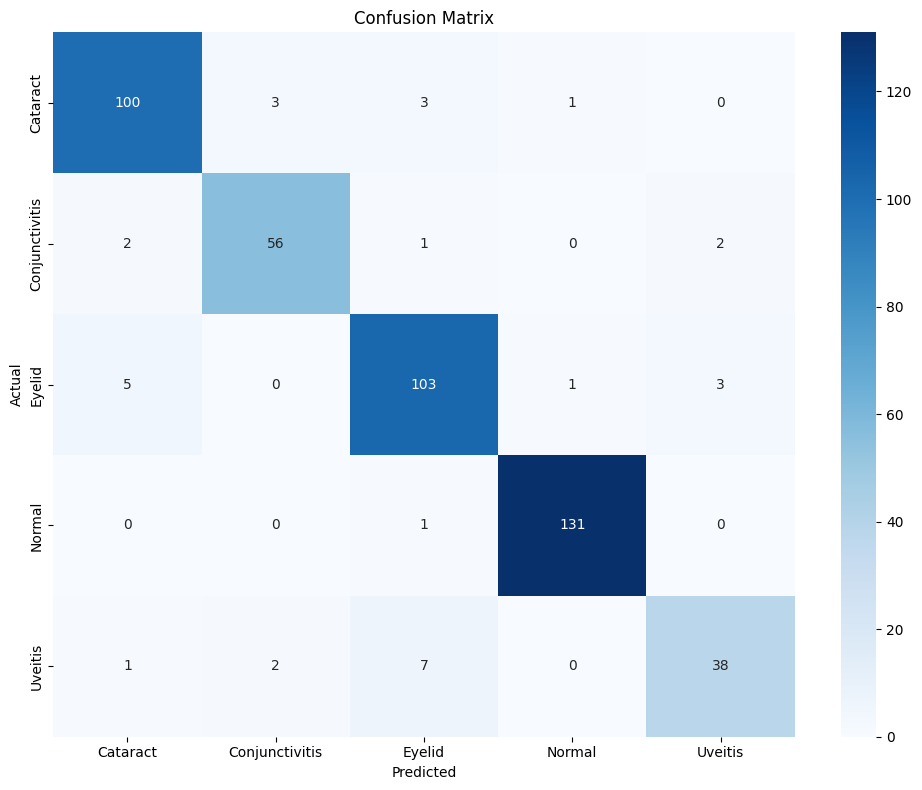

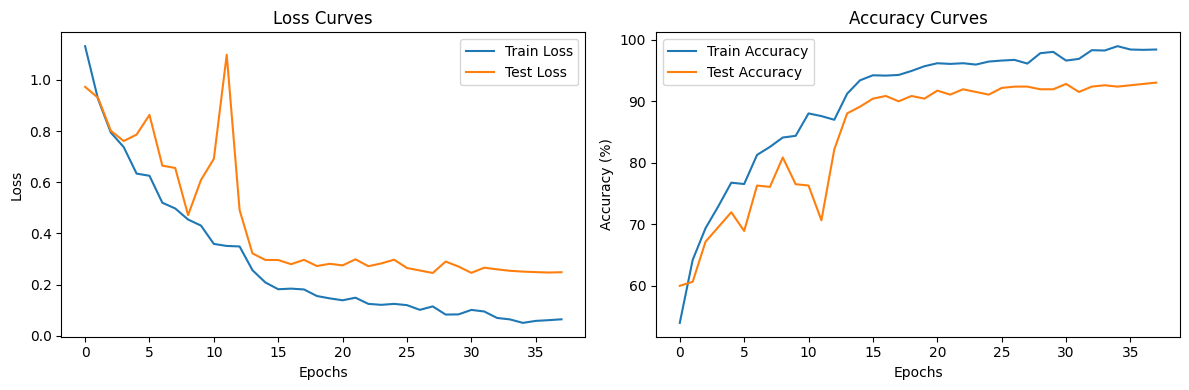

In [49]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
from sklearn.metrics import classification_report, confusion_matrix

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hybrid CNN Model with Attention Mechanism
class ChemicalImageClassifier(nn.Module):
    def __init__(self, num_classes, input_size=224):
        super().__init__()
        
        # CNN Layers with Progressive Depth
        self.cnn_layers = nn.Sequential(
            # Initial layers with increasing depth
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        # Self-Attention Mechanism
        self.attention = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=1),
            nn.Sigmoid()
        )
        
        # Global Average Pooling
        self.gap = nn.AdaptiveAvgPool2d(1)
        
        # Classification Head
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        # CNN Feature Extraction
        features = self.cnn_layers(x)
        
        # Self-Attention Mechanism
        attention_weights = self.attention(features)
        features_attended = features * attention_weights
        
        # Global Average Pooling
        pooled_features = self.gap(features_attended)
        
        # Classification
        return self.classifier(pooled_features)

# Data Preprocessing
def get_data_transforms():
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

# Dataset Loading and Splitting
dataset_path = '/kaggle/input/eye-dataset/Eye-Disease'  # Update this to your dataset path
full_dataset = ImageFolder(dataset_path, transform=get_data_transforms())

# 80-20 Split
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Print Dataset Information
print(f"Total Images: {len(full_dataset)}")
print(f"Training Images: {len(train_dataset)}")
print(f"Testing Images: {len(test_dataset)}")
print(f"Number of Classes: {len(full_dataset.classes)}")
print("Classes:", full_dataset.classes)

# Model Initialization
num_classes = len(full_dataset.classes)
model = ChemicalImageClassifier(num_classes).to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)

# Early Stopping Callback
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0

# Training Loop
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=50):
    early_stopping = EarlyStopping(patience=10)
    
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []
    
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total_train += target.size(0)
            correct_train += (predicted == target).sum().item()
        
        train_loss = total_train_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # Validation
        model.eval()
        total_test_loss = 0
        correct_test = 0
        total_test = 0
        all_preds = []
        all_targets = []
        
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                
                total_test_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                total_test += target.size(0)
                correct_test += (predicted == target).sum().item()
                
                all_preds.extend(predicted.cpu().numpy())
                all_targets.extend(target.cpu().numpy())
        
        test_loss = total_test_loss / len(test_loader)
        test_accuracy = 100 * correct_test / total_test
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        
        scheduler.step(test_loss)
        
        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%')
        print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%')
        
        early_stopping(test_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered!")
            break
    
    # Classification Report
    class_report = classification_report(
        all_targets, 
        all_preds, 
        target_names=full_dataset.classes
    )
    print("\nClassification Report:\n", class_report)
    
    # Confusion Matrix
    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=full_dataset.classes, 
                yticklabels=full_dataset.classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()
    
    return train_losses, test_losses, train_accuracies, test_accuracies

# Run Training
train_losses, test_losses, train_accuracies, test_accuracies = train_model(
    model, train_loader, test_loader, criterion, optimizer
)

# Plot Training Metrics
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.show()